# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

---
The goal of the project is to take in an image from the road and identify the parts of the image that correspont to the lanes of the road. We also want to be able to extend the lanes, so that even when they are dashed lanes we can "imagine" where the line goes in between;

---

## Import Packages
 - **Matplotlib** is for plotting images and charts
 - **cv2** is for dealing with images, it has many useful funcitons for image processing
 - **numpy** is a numeric library with useful and fast vector math functions.
 - **os** is for accessing things from the operating system (os), like files and folders
 - **heapq** provides an implemantation for priority queues, but here we just use the nlargest, nsmallest functions

In [9]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import os
import heapq
%matplotlib inline

## Read in an Image

This is just a quick look at an example image from our test images. We also include the different color channels of the image to remind ourselves that images are composed of 3 different color channels (and also because its kind of neet to look at).

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


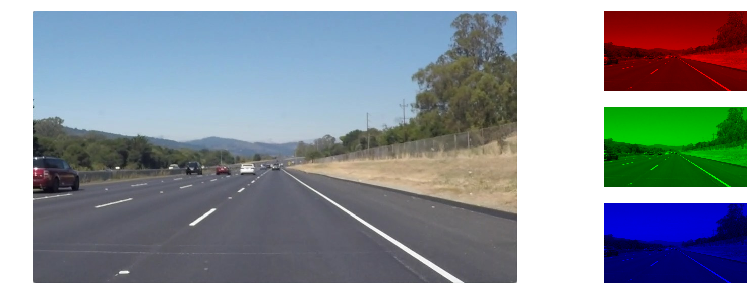

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)

plt.figure(1,figsize=(20,5))
plt.subplot(121)
plt.imshow(image)
plt.axis('off')

#red image
red_image = np.zeros_like(image)
red_image[:,:,0] = image[:,:,0]
plt.subplot(3,6,4)
plt.imshow(red_image)
plt.axis('off')
#green image
green_image = np.zeros_like(image)
green_image[:,:,1] = image[:,:,1]
plt.subplot(3,6,10)
plt.imshow(green_image)
plt.axis('off')
#Blue image
blue_image = np.zeros_like(image)
blue_image[:,:,2] = image[:,:,2]
plt.subplot(3,6,16)
plt.imshow(blue_image)
_=plt.axis('off')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some of the helper functions used for this project

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    p_slopes = []
    n_slopes = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if ((y2-y1)/(x1-x2)) > 0:
                p_slopes.append((y2-y1)/(x1-x2))
            if ((y2-y1)/(x1-x2)) < 0 :
                n_slopes.append(((y2-y1)/(x1-x2)))
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    print('negatives',n_slopes, np.mean(n_slopes))
    print('positives',p_slopes, np.mean(p_slopes))

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, 
                            maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Build a Lane Finding Pipeline

Here we start testing our lane-detecting pipeline. Lets load the test images

In [71]:
import os
image_names = os.listdir("test_images/")

images = []
imgs = []
for image_name in image_names:
    images.append(mpimg.imread('test_images/'+image_name))
    imgs.append(mpimg.imread('test_images/'+image_name))

n = len(images)

Here is a function to help us plot our test images

In [5]:
def plot_examples(images,cmap='gray'):
    plt.figure(figsize=(20,5))
    for i in range(6):
        plt.subplot(1,6,i+1)
        plt.imshow(images[i],cmap=cmap)
        plt.axis('off')
    plt.show()

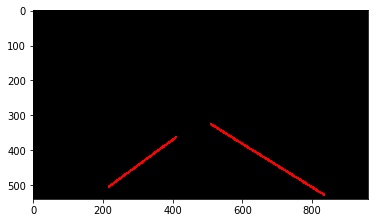

In [75]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    This function draws the lines detected by the hough_lines function. It also does some processing to get a clear
    image of the right and left lanes.
    
    First we find the slope of the line with the formula slope = (y1-y2)/(x1-x2). Here we need to note that the
    y coordinate grows down, so a positive slope means the line goes down towards the right. A negative slope 
    means the line goes up towards the right.
    
    So we can seperate the lines of the right lane from the lines of the left lane looking at the slope.
    Positive slope, right, negative slope, left.
    
    We also want to filter out any lines that are too horizontal since they are probably not from the lanes (unless
    the car is way off track). 
    
    To find a line that represents well each lane we can look for the heisght point of the left lane and join it 
    to the lowest point of the left lane. And do the same for the right lane.
    """
    p_slopes = []
    n_slopes = []
    
    x = 0
    y = 1
    
    
    right_lane_Xs = []
    right_lane_Ys = []
    left_lane_Xs = []
    left_lane_Ys = []
    
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope =((y1-y2)/(x1-x2))
            
            #don't include almost horizontal lines
            if abs(slope) < 0.1 or abs(slope) > 4:
                continue
                
            #a positive slope is from the right side
            if slope > 0:
                p_slopes.append((y2-y1)/(x1-x2))
                right_lane_Xs.append(x1)
                right_lane_Xs.append(x2)
                right_lane_Ys.append(y1)
                right_lane_Ys.append(y2)
                
            # a negative slope is from the left side
            if slope < 0 :
                n_slopes.append(((y2-y1)/(x1-x2)))
                left_lane_Xs.append(x1)
                left_lane_Xs.append(x2)
                left_lane_Ys.append(y1)
                left_lane_Ys.append(y2)
                
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    #print('negatives', np.mean(n_slopes))
    #print('positives', np.mean(p_slopes))
    N = 10
    right_lane = (np.median(heapq.nlargest(N,right_lane_Xs)),np.median(heapq.nlargest(N,right_lane_Ys)),
                  np.median(heapq.nsmallest(N,right_lane_Xs)),np.median(heapq.nsmallest(N,right_lane_Ys)))
    #print(right_lane)
    left_lane = (np.median(heapq.nsmallest(N,left_lane_Xs)),np.median(heapq.nlargest(N,left_lane_Ys)),
                 np.median(heapq.nlargest(N,left_lane_Xs)), np.median(heapq.nsmallest(N,left_lane_Ys)))
    #print(left_lane)

    x1,y1,x2,y2 = (int(x) for x in right_lane)
    thickness = 5
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    x1,y1,x2,y2 = (int(x) for x in  left_lane)
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    

i = 5

images[i] = mpimg.imread('test_images/'+image_names[i])
images[i] = grayscale(images[i])
images[i] = gaussian_blur(images[i],3)
images[i] = canny(images[i],50,150)
images[i] = region_of_interest(images[i], np.int32([vertices]))
images[i] = hough_lines(images[i], rho, theta, threshold, min_line_len, max_line_gap)
#images[i] = weighted_img(images[i], imgs[i], α=0.8, β=1., λ=0.)
plt.imshow(images[i], cmap='gray')

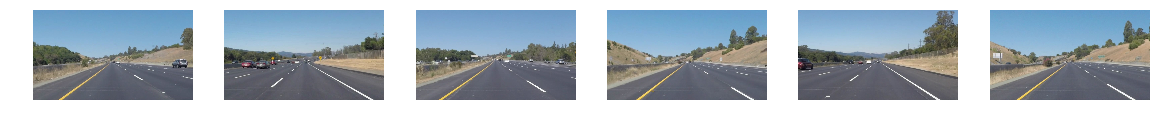

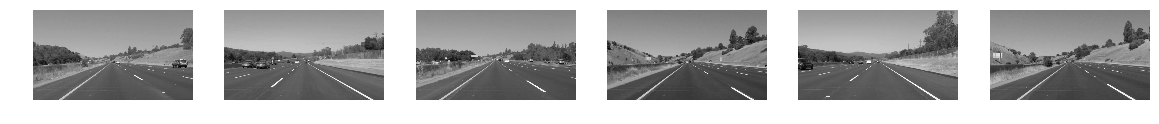

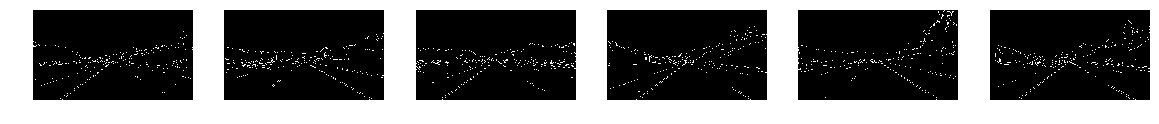

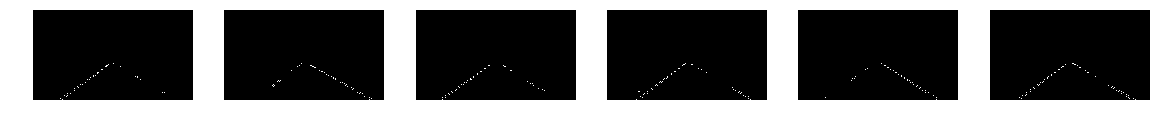

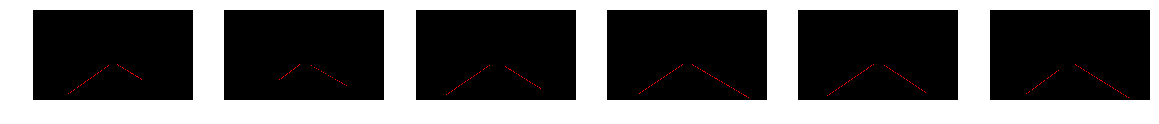

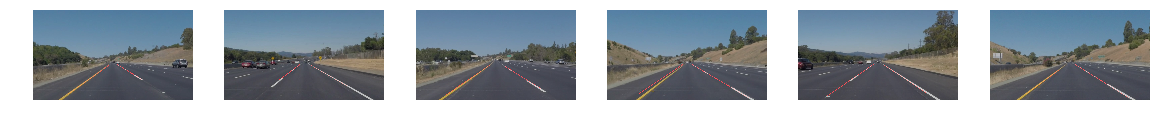

In [72]:
#print('original images')
plot_examples(images)
# TODO: Build your pipeline that will draw lane lines on the test_images
#Grey scale
for i in range(n):
    images[i] = grayscale(images[i])
#print('gray scaled images')
plot_examples(images)

#Canny Edges
for i in range(n):
    images[i] = gaussian_blur(images[i],3)
    images[i] = canny(images[i],50,150)
#print('Edges of images')
plot_examples(images)


#Region of interrest
y_size, x_size = images[0].shape
vertices = np.array([(x_size*0.05,y_size),
                     (x_size*0.48,y_size*0.59),
                     (x_size*0.52,y_size*0.59),
                     (x_size*0.95,y_size)])
for i in range(n):
    images[i] = region_of_interest(images[i], np.int32([vertices]))
#print('lines in region of interrest')
plot_examples(images)

#Hough transform
rho = 1
theta = math.pi/180
threshold = 10
min_line_len = 5
max_line_gap = 5
for i in range(n):
    images[i] = hough_lines(images[i], rho, theta, threshold, min_line_len, max_line_gap)
#print('lines joining  edges')
plot_examples(images)


results = []
for i in range(n):
    images[i] = weighted_img(images[i], imgs[i], α=0.8, β=1., λ=0.)
#print('lines over original image')
plot_examples(images)
#Extrapolate

# then save them to the test_images directory.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [58]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    img = image
    image = grayscale(image)
    image = gaussian_blur(image,5)
    image = canny(image,50,150)
    rho = 1
    theta = math.pi/180
    threshold = 10
    min_line_len = 10
    max_line_gap = 10
    y_size, x_size = image.shape
    vertices = np.array([(x_size*0.05,y_size),
                     (x_size*0.48,y_size*0.59),
                     (x_size*0.52,y_size*0.59),
                     (x_size*0.95,y_size)])
    image = region_of_interest(image, np.int32([vertices]))
    lines_image = hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap)
    result = weighted_img(lines_image, img, α=0.8, β=1., λ=0.)
    return result

Let's try the one with the solid white lane on the right first ...

In [73]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



 99%|█████████▉| 125/126 [00:07<00:00, 17.33it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.69 s, sys: 340 ms, total: 4.03 s
Wall time: 9.39 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [74]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [67]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



 99%|█████████▉| 125/126 [00:06<00:00, 18.27it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 3.73 s, sys: 348 ms, total: 4.08 s
Wall time: 8.91 s


In [68]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [65]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
##clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



 99%|█████████▉| 125/126 [00:15<00:00,  5.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 7.3 s, sys: 612 ms, total: 7.91 s
Wall time: 20.4 s


In [66]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))